In [8]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share

bp.math.set_dt(0.04)

In [10]:
class A2(bp.neurons.HH):
    def __init__(self, size, ENa=115., EK=-12., EL=10.6, C=1.0, gNa=120.,
               gK=36, gL=0.3, V_th=0., method='exp_auto'):
        super().__init__(size=size, method=method)
        self.size = size

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        self.input = bm.Variable(bm.ones(size) * 1)
        self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    def dm(self, m, t, V):
        alpha = 0.1 * (25-V) / (bm.exp(-0.1 * (V - 25)) - 1)
        beta = 4 * bm.exp(-V / 18)
        dmdt = alpha * (1 - m) - beta * m
        return dmdt

    def dn(self, n, t, V):
        alpha = 0.01 * (10-V) / (bm.exp(0.1 * (10-V)) - 1)
        beta = 0.125 * bm.exp(-V / 80)
        dndt = alpha * (1 - n) - beta * n
        return  dndt

    def dh(self, h, t, V):
        alpha = 0.07 * bm.exp(-V / 20)
        beta = 1 / (bm.exp(0.1 * (-V + 30)) + 1)
        dhdt = alpha * (1 - h) - beta * h
        return dhdt

    def dV(self, V, t, m, h, n, I):
        INa = self.gNa * m ** 3 * h * (V - self.ENa)
        IK = self.gK * n ** 4 * (V - self.EK)
        IL = self.gL * (V - self.EL)
        dVdt = (- INa - IK - IL + I) / self.C
        return dVdt

    @property
    def derivative(self):
        return JointEq(self.dV, self.dm, self.dh, self.dn)  # , self.dh, self.dn, self.ds, self.dc, self.dq)

    def update(self, tdi):
        # t = share.load('t')
        # dt = share.load('dt')
        # x = 1.2 if x is None else x
        # print('x=', x )

        V, m, h, n = self.integral(self.V.value, self.m.value, self.h.value, self.n.value, tdi.t, self.input, tdi.dt)
        # V += self.sum_delta_inputs()
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        # self.t_last_spike.value = bm.where(self.spike, tdi.t, self.t_last_spike)
        self.V.value = V
        self.h.value = h
        self.n.value = n
        self.input[:] = 0
        return self.spike.value


num = 100
# dyn neurons
neu =  A2(num) #A1(num) #bp.neurons.HH(num)#bp.dyn.HH(10) #HH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num) #bp.dyn.WangBuzsakiHH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num)
# neu = bp.neurons.HH(100)

In [3]:
#neu = bp.neurons.HH(100)

In [ ]:
# print(neu.V.value,neu.m.value, neu.h.value, neu.n.value)
neu.V[:] = neu.V[:].value #. + bm.random.normal(size=num) 
# neu.V[:] = -70. + bm.random.normal(size=num) 
alpha_m = 0.1 * (25-neu.V) / (bm.exprel(-0.1 * (neu.V - 25)) - 1)
#1. / bm.exprel(-(neu.V + 40) / 10) #0.1 * (25-neu.V[:]) / (bm.exp(-0.1 * (neu.V[:] - 25)) - 1)
beta_m = 4 * bm.exp(-neu.V[:] / 18)
#4.0 * bm.exp(-(neu.V + 65) / 18) #4 * bm.exp(-neu.V[:] / 18)
neu.m[:] = alpha_m/ (alpha_m + beta_m)
alpha_h = 0.07 * bm.exp(-neu.V / 20)
#0.07 * bm.exp(-(neu.V + 65) / 20.) # 0.07 * bm.exp(-neu.V / 20)
beta_h = 1 / (bm.exp(0.1 * (-neu.V + 30)) + 1) #
#1 / (1 + bm.exp(-(neu.V + 35) / 10)) #1 / (bm.exp(0.1 * (-neu.V + 30)) + 1)
neu.h[:] = alpha_h/ (alpha_h + beta_h)
alpha_n = 0.01 * (10-neu.V) / (bm.exprel(0.1 * (10-neu.V)) - 1) #0.1 / bm.exprel(-(V + 55) / 10) #
beta_n = 0.125 * bm.exp(-neu.V / 80) #0.125 * bm.exp(-(V + 65) / 80) #
neu.n[:] = alpha_n/ (alpha_n + beta_n)
print(round(bm.mean(neu.m),3), round(bm.mean(neu.h),3),round(bm.mean(neu.n),3))

In [20]:
class BaseAMPASyn(bp.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.1/100, E=20, alpha=0.98,
               beta=0.18, 
               T=1, T_duration=1, method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)

    def derivative(self, g, t, TT):
        #dg = self.alpha * TT * (1 - g) - self.beta * g
        dg = self.alpha * TT * (1 - g) - self.beta * g
        return dg

class AMPAAll2All(BaseAMPASyn):
    def __init__(self, *args, **kwargs):
        super(AMPAAll2All, self).__init__(*args, **kwargs)

        self.conn_mat = self.conn.require('conn_mat').astype(float)

        # synapse gating variable
        # -------
        # The synapse variable has the shape of the post-synaptic group
        self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
        # self.g = bm.Variable(bm.zeros( self.post.num))

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        delayed_spike = self.pre_spike(self.delay_step)
        self.pre_spike.update(self.pre.spike)
        self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
        TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
              #*1/(1+bm.exp(-(self.pre.V-20)/2)))
        # TT = 1/(1+bm.exp(-(self.pre.V+3)/8))
        TT = TT.reshape((-1, 1))  # NOTE: here is the difference
        # print('shape of TT=', TT.shape)
        # TT = TT.reshape((-1, 1))*self.g_max  # NOTE: here is the difference
        # TT2 =  self.g_max @ TT.reshape((-1, 1))
        # # TT = bm.dot(TT,self.g_max )
        # print('shape of TT after =', TT2, TT[:10])
        self.g.value = self.integral(self.g, _t, TT, dt=_dt)
        # print('g ki value=', self.g.value)
        # g_post =  bm.dot(self.g_max, self.g )
        # print('g_post= ', g_post)
        g_post = self.g.sum(axis=0) # NOTE: here is also different

         # update synapse states according to the pre spikes
        # post_sps = bm.dot(delayed_spike.astype(float), self.g_max)
        # print('a quick check=', self.g)
        # print('*'*10)
        #self.g += post_sps
        # get the post-synaptic current
        # self.post.input += #self.g_max,g_post * (self.E - self.post.V)/99 #20
        self.post.input += bm.dot(self.g_max,g_post) * (self.E - self.post.V)/99 #20
        # self.post.input += g_post * (self.E - self.post.V)/99 #20
        # self.post.input += (self.g_max * g_post) * (self.E - self.post.V)/100

        # self.post.input += self.g_max * g_post * (self.E - self.post.V)
        print('output =', self.post.input)
        
    

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.SynConn is deprecated. Use brainpy.dyn.SynConn instead.
  _deprecate(message)


  0%|          | 0/12500 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


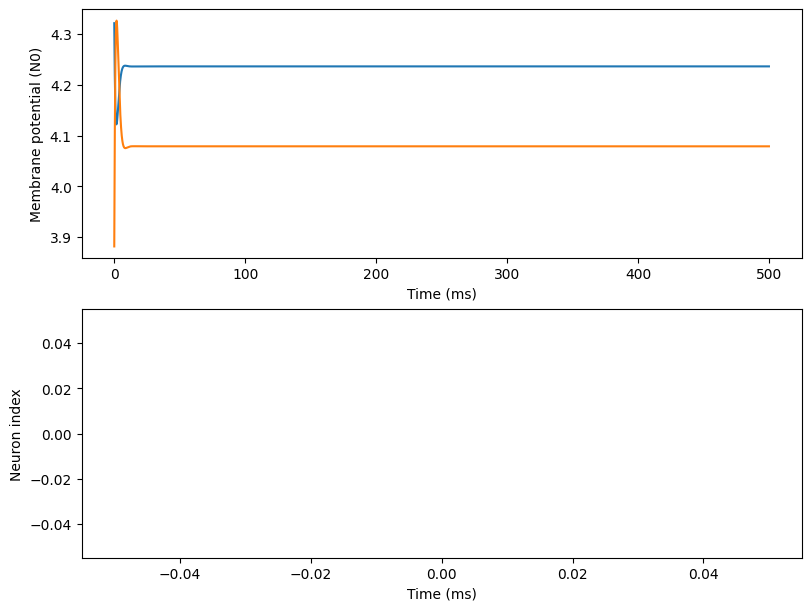

In [21]:
    
syn = AMPAAll2All(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False)) #include_self=False)) #,stop_spike_gradient=False)
# syn = AMPAAll2All(pre=neu, post=neu, conn= bp.connect.FixedProb(prob=0.2, include_self=True))
# syn = bp.dyn.GABAa.desc(pre=neu, post=neu, prob=1) #conn=bp.connect.All2All(include_self=False)) #,stop_spike_gradient=False)

shape = (100,100)
syn.g_max = bp.init.Normal(mean=0.1, scale=0.02)(shape) #.value
print('='*100)
# neu = HH(10)
# V, spike

# net = bp.Network(pre=neu, post=neu ,syn=syn)
net = bp.Network(neu=neu, syn=syn)
# runner = bp.DSRunner(net, monitors=['pre.spike', 'pre.V','post.spike', 'post.V'], inputs=[('pre.input',1.2,'fix', '+'), ('post.input',120)]) #,'fix', '=']) # bm.random.normal(1,0.02,num)])
# runner = bp.DSRunner(neu, monitors=['V','spike'], inputs=['input',1.2]) #,'fix','+']) # bm.random.normal(1,0.02,num)])
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',bm.random.uniform(9,10,100)]) #
runner.run(duration=500.) #,inputs=inputs )


# a = bp.DynamicalSystem() #bp.Dynamic
# #a.input
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'][:,10])

# bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,0], ylabel='Membrane potential (N0)')
# bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,1])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()

# fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
#
# fig.add_subplot(gs[0, 0])
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,0], ylabel='Membrane potential (N0)')
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,1])
# bp.visualize.line_plot(runner.mon.ts, runner.mon['V'][:,10])
#
# # bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,0], ylabel='Membrane potential (N0)')
# # bp.visualize.line_plot(runner.mon.ts, runner.mon.V[:,1])
#
# fig.add_subplot(gs[1, 0])
# # bp.visualize.raster_plot(runner.mon.ts, runner.mon['pre.spike'], show=True)
# bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], show=True)
# plt.show()